In [1]:
!pip install aquirdturtle_collapsible_headings
!pip install 'python-lsp-server[all]'
!pip install jupyterlab-spellchecker
!pip install jupyterlab-code-formatter

  Using cached jupyterlab-3.6.8-py3-none-any.whl.metadata (12 kB)
Using cached jupyterlab-3.6.8-py3-none-any.whl (8.9 MB)
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.4.1
    Uninstalling jupyterlab-4.4.1:
      Successfully uninstalled jupyterlab-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-spellchecker 0.8.4 requires jupyterlab<5,>=4, but you have jupyterlab 3.6.8 which is incompatible.
  Using cached jupyterlab-4.4.1-py3-none-any.whl.metadata (16 kB)
Using cached jupyterlab-4.4.1-py3-none-any.whl (12.3 MB)
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 3.6.8
    Uninstalling jupyterlab-3.6.8:
      Successfully uninstalled jupyterlab-3.6.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [2]:
!pip install numpy pandas scikit-learn shap scipy kagglehub

In [8]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from scipy.optimize import bisect # Although Gap Stat is not implemented, keep import if used in future extensions

class ARSK(BaseEstimator, ClusterMixin):
    """
    Implementação do algoritmo Adaptively Robust and Sparse K-means Clustering (ARSK)
    baseado em Li, Sugasawa e Katayama (2024+).
    """
    def __init__(self, n_clusters=3, alpha=0.1, lambda1=None, lambda2=None,
                 penalty_e='group_lasso', penalty_w='lasso',
                 n_init=10, max_iter=100, tol=1e-4, random_state=None):
        """
        Inicializa o ARSK.

        Args:
            n_clusters (int): O número de clusters.
            alpha (float): Proporção de pontos usados para inicializar E (e usado na lógica interna de trimming).
                           Deve estar entre 0 e 1. No artigo R code, 0.2 é usado para inicialização.
            lambda1 (float or None): Parâmetro de ajuste para a penalidade na matriz de erro E (robustez).
                                     Controla o nível de detecção de outliers. Valores maiores -> menos outliers detectados.
                                     Se None, seria otimizado via Gap Statistics (não implementado aqui).
            lambda2 (float or None): Parâmetro de ajuste para a penalidade nos pesos das variáveis w (esparsidade).
                                     Controla o nível de seleção de features. Valores maiores -> mais pesos zero (mais esparsidade).
                                     Se None, seria otimizado via Gap Statistics (não implementado aqui).
            penalty_e (str): Tipo de penalidade para a matriz de erro E ('group_lasso' ou 'group_scad').
            penalty_w (str): Tipo de penalidade para os pesos das variáveis w ('lasso' ou 'scad').
            n_init (int): Número de vezes que o algoritmo será executado com diferentes inicializações de centros.
            max_iter (int): Número máximo de iterações do algoritmo principal de otimização (iteração entre E e w).
            tol (float): Tolerância para convergência do algoritmo principal (baseado na mudança relativa dos pesos).
            random_state (int or None): A semente para o gerador de números aleatórios para inicialização.
        """
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.penalty_e = penalty_e
        self.penalty_w = penalty_w
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        if not 0 <= self.alpha <= 1:
             raise ValueError("alpha deve estar entre 0 e 1.")
        if self.penalty_e not in ['group_lasso', 'group_scad']:
            raise ValueError("penalty_e deve ser 'group_lasso' ou 'group_scad'.")
        if self.penalty_w not in ['lasso', 'scad']:
            raise ValueError("penalty_w deve ser 'lasso' ou 'scad'.")
        if self.lambda1 is None or self.lambda2 is None:
             print("Warning: lambda1 or lambda2 is None. Parameter tuning via Gap Statistics is not implemented.")
             print("Please provide lambda1 and lambda2 values. Using default values 0.1 for demonstration.")
             # Using default values for demonstration, ideally these would be tuned.
             if self.lambda1 is None: self.lambda1 = 0.1
             if self.lambda2 is None: self.lambda2 = 0.1


        # Atributos que serão definidos após o fit
        self.cluster_centers_ = None # Centers in the original data space for points assigned to clusters
        self.labels_ = None # Cluster labels for all points
        self.weights_ = None # Learned feature weights
        self.error_matrix_ = None # Learned error matrix (unweighted)
        self.n_iter_ = None # Number of iterations for the best run

    def _initialize_centers(self, X):
        """
        Inicializa os centros do cluster usando K-means++.
        """
        # Use standard K-means++ on original data for initial centers.
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
        kmeans.fit(X)
        return kmeans.cluster_centers_

    def _soft_threshold(self, x, threshold):
        """ Soft Thresholding para escalar ou vetor. """
        return np.sign(x) * np.maximum(0, np.abs(x) - threshold)

    def _scad_threshold(self, x, threshold, a=3.7):
        """ SCAD Thresholding para escalar ou vetor. """
        abs_x = np.abs(x)
        # Componentes para aplicar thresholding
        e1 = abs_x <= threshold
        e2 = (abs_x > threshold) & (abs_x <= a * threshold)

        # Aplicar thresholding
        res = np.zeros_like(x)
        res[e1] = self._soft_threshold(x[e1], threshold)
        res[e2] = ((a - 1) * x[e2] - np.sign(x[e2]) * a * threshold) / (a - 2)
        res[abs_x > a * threshold] = x[abs_x > a * threshold]

        return res


    def _multivariate_soft_threshold(self, z, threshold):
        """ Multivariate Soft Thresholding para vetores (linhas de E). """
        # Applies thresholding to the L2 norm of each row vector in z.
        norm_z = np.linalg.norm(z, axis=1, keepdims=True)
        # Avoid division by zero where norm_z is zero or very small
        scale = np.maximum(0, 1 - threshold / (norm_z + 1e-9))
        return z * scale

    def _multivariate_scad_threshold(self, z, threshold, a=3.7):
        """ Multivariate SCAD Thresholding para vetores (linhas de E). """
        # Applies thresholding to the L2 norm of each row vector in z.
        norm_z = np.linalg.norm(z, axis=1, keepdims=True)
        # Componentes para aplicar thresholding based on norm
        e1 = norm_z <= 2 * threshold
        e2 = (norm_z > 2 * threshold) & (norm_z <= a * threshold)

        # Apply thresholding
        res = np.zeros_like(z)
        # For the first part, it's the same as multivariate soft thresholding
        res[e1[:, 0], :] = self._multivariate_soft_threshold(z[e1[:, 0], :], threshold)

        # For the second part, scaled version of soft thresholding
        # z_subset = z[e2[:, 0], :] # Select rows where 2*lambda < norm <= a*lambda
        # threshold_scaled = (a * threshold) / (a - 1)
        # res[e2[:, 0], :] = ((a - 1) / (a - 2)) * self._multivariate_soft_threshold(z_subset, threshold_scaled)
        # The R code's interpretation seems simpler, applying scalar SCAD to the norm and scaling the vector.
        # Let's stick to the R code's SCAD implementation for E (which is different from the paper's Eq 8).
        # R code SCAD for E: (x-m) / norm(x-m) * S(norm(x-m), lambda) where S is scalar SCAD.
        # Let's implement this R code logic as it seems to be what the authors used.
        norms = np.linalg.norm(z, axis=1)
        # Avoid division by zero
        non_zero_norm_mask = norms > 1e-9
        res[non_zero_norm_mask, :] = z[non_zero_norm_mask, :] / norms[non_zero_norm_mask].reshape(-1, 1) * self._scad_threshold(norms[non_zero_norm_mask], threshold, a).reshape(-1, 1)
        # Rows where norm is zero remain zero, which is correct.

        return res


    def _calculate_qr(self, X_prime, labels):
        """
        Calcula Q_j^R, a medida robusta de separação entre clusters para cada feature j,
        usando os dados ajustados X' = X - E.
        Q_j^R is proportional to the Between-cluster Sum of Squares on X'.
        """
        n_samples, n_features = X_prime.shape
        Qr_j = np.zeros(n_features)

        # Calculate overall mean for each feature in X_prime
        mean_prime = np.mean(X_prime, axis=0)

        for j in range(n_features):
            # Total Sum of Squares for feature j in X_prime
            SS_total_j_prime = np.sum((X_prime[:, j] - mean_prime[j])**2)

            # Within-cluster Sum of Squares for feature j in X_prime
            SS_within_j_prime = 0
            for k in range(self.n_clusters):
                cluster_points_j_prime = X_prime[labels == k, j]
                if len(cluster_points_j_prime) > 0:
                    mean_k_j_prime = np.mean(cluster_points_j_prime)
                    SS_within_j_prime += np.sum((cluster_points_j_prime - mean_k_j_prime)**2)

            # Between-cluster Sum of Squares for feature j is SS_total - SS_within
            Qr_j[j] = SS_total_j_prime - SS_within_j_prime

        return Qr_j


    def _update_weights(self, X_prime, lambda2):
        """
        Atualiza os pesos das variáveis w.
        Uses the adjusted data X_prime = X - E and applies thresholding to Q_j^R.
        """
        n_features = X_prime.shape[1]

        # Calculate Q_j^R for each feature on the adjusted data X_prime
        # Need labels from the current iteration. Pass labels as argument.
        # Qr_j calculation needs to be based on the current clustering partition.
        # Let's pass labels from the fit method.
        raise NotImplementedError("Labels needed to calculate Qr_j in _update_weights") # This function should be called with labels

    def _update_weights_with_labels(self, X_prime, labels, lambda2):
        """
        Atualiza os pesos das variáveis w, given labels.
        Uses the adjusted data X_prime = X - E and applies thresholding to Q_j^R.
        """
        n_features = X_prime.shape[1]

        # Calculate Q_j^R for each feature on the adjusted data X_prime and current labels
        Qr_j = self._calculate_qr(X_prime, labels)

        # Apply thresholding to Qr_j
        if self.penalty_w == 'lasso':
             S_Qr_j = self._soft_threshold(Qr_j, lambda2)

        elif self.penalty_w == 'scad':
             # Apply scalar SCAD thresholding to Qr_j
             S_Qr_j = self._scad_threshold(Qr_j, lambda2)


        # Normalize weights to have L2 norm of 1
        norm_S_Qr_j = np.linalg.norm(S_Qr_j)

        if norm_S_Qr_j > 1e-9: # Avoid division by zero or very small numbers
            weights = S_Qr_j / norm_S_Qr_j
        else:
            # If all thresholded Qr_j are zero, all weights become zero.
            # Return zero weights in this case.
            weights = np.zeros(n_features)

        return weights


    def fit(self, X, y=None):
        """
        Ajusta o modelo ARSK aos dados.

        Args:
            X (np.ndarray): O conjunto de dados de entrada com forma (n_samples, n_features).
            y (Ignored): Ignorado, existe por compatibilidade com a API do scikit-learn.

        Returns:
            self: O objeto ajustado.
        """
        X = check_array(X)
        n_samples, n_features = X.shape

        # Ensure lambda1 and lambda2 are not None (or handle tuning here)
        if self.lambda1 is None or self.lambda2 is None:
             # This warning is already in __init__, but repeat as fit is the main user-facing method.
             print("Warning: lambda1 or lambda2 is None. Parameter tuning via Gap Statistics is not implemented.")
             print("Please provide lambda1 and lambda2 values. Using default values 0.1 for demonstration.")
             if self.lambda1 is None: self.lambda1 = 0.1
             if self.lambda2 is None: self.lambda2 = 0.1


        best_labels = None
        best_centers = None
        best_weights = None
        best_error_matrix = None
        # Using the objective function value (or a proxy like weighted inertia) as a criterion for best run
        best_objective_value = -np.inf # We are maximizing L, so start with negative infinity

        # Set random seed for reproducibility across initializations
        np.random.seed(self.random_state)

        for init_run in range(self.n_init):
            # Initialize centers using K-means++ on the original data
            current_centers_original_space = self._initialize_centers(X)

            # Initialize weights (Algorithm 1, Step 1)
            current_weights = np.ones(n_features) / np.sqrt(n_features)

            # Initialize Error Matrix E (Algorithm 1, Step 2)
            # Based on the R code and paper, initialize E for a proportion of the farthest points.
            overall_mean = np.mean(X, axis=0)
            distances_to_mean = np.linalg.norm(X - overall_mean, axis=1)
            num_initial_outliers = int(n_samples * self.alpha) # Use alpha for initialization proportion
            farthest_indices = np.argsort(distances_to_mean)[-num_initial_outliers:]
            current_error_matrix = np.zeros_like(X)
            current_error_matrix[farthest_indices, :] = X[farthest_indices, :] # Initialize E for farthest points

            previous_weights = np.copy(current_weights) # For convergence check

            for iter in range(self.max_iter):
                # Algorithm 1, Step 3: repeat main loop

                # Calculate the data adjusted by E from the previous iteration
                X_adjusted_prev_E = X - current_error_matrix

                # Algorithm 1, Step 4: Run clustering on X_adjusted_prev_E weighted by current weights.
                # The centers obtained here are in the space (X-E_prev).w
                X_for_kmeans = X_adjusted_prev_E * current_weights.reshape(1, -1)
                kmeans = KMeans(n_clusters=self.n_clusters, n_init=1,
                                max_iter=50, # Allow K-means to converge a bit
                                random_state=self.random_state + iter if self.random_state is not None else iter)
                kmeans.fit(X_for_kmeans)
                current_labels = kmeans.labels_
                # current_centers_transformed_space = kmeans.cluster_centers_ # Centers in (X-E_prev).w space

                # Recalculate centers in the *original* space based on the current labels
                current_centers_original_space = np.zeros_like(current_centers_original_space)
                for k in range(self.n_clusters):
                    cluster_points_indices = np.where(current_labels == k)[0]
                    if len(cluster_points_indices) > 0:
                        current_centers_original_space[k, :] = np.mean(X[cluster_points_indices], axis=0)
                    # else: center remains zero

                # Algorithm 1, Step 5 & 6: Calculate new E
                # Based on R code logic: Update E based on (X . w) and centers of (X . w).
                # This seems inconsistent with the paper's objective, but let's follow the R code's apparent logic.
                # Calculate centers of weighted X based on current labels
                weighted_X = X * current_weights.reshape(1, -1)
                centers_of_weighted_X = np.zeros_like(current_centers_original_space) * current_weights.reshape(1, -1) # Centers in weighted space
                for k in range(self.n_clusters):
                     cluster_points_weighted_X = weighted_X[current_labels == k, :]
                     if len(cluster_points_weighted_X) > 0:
                          centers_of_weighted_X[k, :] = np.mean(cluster_points_weighted_X, axis=0)

                # Difference for E update: weighted_X - centers_of_weighted_X[labels, :]
                diff_for_e_update = weighted_X - centers_of_weighted_X[current_labels, :]

                # Apply multivariate thresholding to diff_for_e_update
                if self.penalty_e == 'group_lasso':
                     current_error_matrix_weighted = self._multivariate_soft_threshold(diff_for_e_update, self.lambda1)
                elif self.penalty_e == 'group_scad':
                      # Use R code's multivariate SCAD logic
                      current_error_matrix_weighted = self._multivariate_scad_threshold(diff_for_e_update, self.lambda1)


                # Algorithm 1, Step 8: Restore E by dividing by w or 1 if w=0.
                tata = np.where(current_weights == 0, 1, current_weights)
                current_error_matrix = current_error_matrix_weighted / tata.reshape(1, -1) # This is now the unweighted E


                # Algorithm 1, Step 9: Compute Q_j^R on X' = X - current_error_matrix

                # Algorithm 1, Step 10: Compute new variable weight w
                X_prime_current_E = X - current_error_matrix
                new_weights = self._update_weights_with_labels(X_prime_current_E, current_labels, self.lambda2)

                # Algorithm 1, Step 11: check convergence
                # Convergence criterion: sum(|w_new - w_old|) / sum(|w_old|) < epsilon
                sum_abs_w_old = np.sum(np.abs(previous_weights))
                if sum_abs_w_old < 1e-9: # Handle initial state or convergence to zero weights
                     weight_change = np.inf if np.sum(np.abs(new_weights)) > 1e-9 else 0
                else:
                    weight_change = np.sum(np.abs(new_weights - previous_weights)) / sum_abs_w_old

                previous_weights = np.copy(new_weights) # Update previous weights for next iteration
                current_weights = new_weights # Update current weights

                # Store objective value (or a proxy) for this iteration to select best run
                # The objective L is complex. A simpler proxy for evaluation is weighted inertia on X'.
                X_prime_current = X - current_error_matrix
                weighted_X_prime_current = X_prime_current * current_weights.reshape(1, -1)
                current_centers_weighted_prime = np.zeros_like(current_centers_original_space) * current_weights.reshape(1, -1)
                for k in range(self.n_clusters):
                    cluster_points_weighted_prime = weighted_X_prime_current[current_labels == k, :]
                    if len(cluster_points_weighted_prime) > 0:
                        current_centers_weighted_prime[k, :] = np.mean(cluster_points_weighted_prime, axis=0)

                current_inertia = 0
                for k in range(self.n_clusters):
                    cluster_points_weighted_prime = weighted_X_prime_current[current_labels == k, :]
                    if len(cluster_points_weighted_prime) > 0:
                        current_inertia += np.sum((cluster_points_weighted_prime - current_centers_weighted_prime[k])**2)

                # The paper maximizes L. Minimizing inertia on the transformed data is consistent with K-means goal.
                # Let's use negative inertia as the objective value to maximize.
                current_objective_value = -current_inertia


                if weight_change < self.tol:
                    # print(f"Init {init_run}: Converged after {iter+1} iterations.")
                    self.n_iter_ = iter + 1 # Store iterations for this run
                    break # Converged
                # If max_iter reached without convergence
                if iter == self.max_iter - 1:
                    self.n_iter_ = self.max_iter # Store max_iter if not converged


            # After convergence or max_iter, check if this run is the best
            if current_objective_value > best_objective_value: # Maximize objective (minimize inertia)
                 best_objective_value = current_objective_value
                 best_labels = current_labels
                 # Store centers in original space based on the final labels
                 best_centers = np.zeros_like(current_centers_original_space)
                 for k in range(self.n_clusters):
                    cluster_points_indices = np.where(best_labels == k)[0]
                    if len(cluster_points_indices) > 0:
                        best_centers[k, :] = np.mean(X[cluster_points_indices], axis=0)

                 best_weights = current_weights
                 best_error_matrix = current_error_matrix # Store the unweighted error matrix
                 best_n_iter = self.n_iter_ # Store iterations for the best run


        # Store the results from the best initialization run
        self.labels_ = best_labels
        self.cluster_centers_ = best_centers # Centers in original space
        self.weights_ = best_weights
        self.error_matrix_ = best_error_matrix # Unweighted error matrix
        self.n_iter_ = best_n_iter # Iterations for the best run


        return self

    def predict(self, X):
        """
        Prevê o cluster mais próximo para cada ponto em X usando os pesos aprendidos.

        Args:
            X (np.ndarray): O conjunto de dados de entrada com forma (n_samples, n_features).

        Returns:
            np.ndarray: Os rótulos do cluster previstos para cada ponto em X.
        """
        check_is_fitted(self)
        X = check_array(X)

        if self.weights_ is None or self.cluster_centers_ is None:
             raise RuntimeError("O modelo não foi ajustado. Chame fit primeiro.")

        # Predict based on weighted distance to cluster centers in the original space.
        # Weighted squared Euclidean distance: sum_j w_j * (X_ij - mu_kj)^2 as per Witten & Tibshirani (2010)
        weighted_X = X * np.sqrt(self.weights_.reshape(1, -1)) # Weighted X for distance calculation
        weighted_centers = self.cluster_centers_ * np.sqrt(self.weights_.reshape(1, -1)) # Weighted centers

        distances = euclidean_distances(weighted_X, weighted_centers, squared=True)
        return np.argmin(distances, axis=1)


    def transform(self, X):
         """
         Transforma os dados aplicando os pesos aprendidos.
         Useful for visualizing the data in the selected feature space.

         Args:
             X (np.ndarray): O conjunto de dados de entrada com forma (n_samples, n_features).

         Returns:
             np.ndarray: Os dados transformados com forma (n_samples, n_features).
                         Features with zero weights will be zeroed out.
         """
         check_is_fitted(self)
         X = check_array(X)
         if self.weights_ is None:
              raise RuntimeError("O modelo não foi ajustado. Chame fit primeiro.")

         return X * self.weights_.reshape(1, -1)


    def evaluate(self, X, true_labels=None):
        """
        Fornece informações para avaliação.
        Includes labels, weights, and error matrix (indicating detected outliers).
        Can also compute Adjusted Rand Index if true_labels are provided.

        Args:
            X (np.ndarray): O conjunto de dados de entrada.
            true_labels (np.ndarray, optional): Os rótulos verdadeiros, se disponíveis.

        Returns:
            dict: Um dicionário contendo 'labels', 'weights', 'error_matrix' (outliers),
                  'outlier_indices', e opcionalmente 'adjusted_rand_score'.
        """
        check_is_fitted(self)
        results = {
            'labels': self.labels_,
            'weights': self.weights_,
            'error_matrix': self.error_matrix_,
            # Outliers are points where the corresponding row in the *final* error matrix is non-zero
            'outlier_indices': np.where(np.linalg.norm(self.error_matrix_, axis=1) > 1e-9)[0].tolist()
        }

        if true_labels is not None:
            from sklearn.metrics import adjusted_rand_score
            # Evaluate clustering performance using Adjusted Rand Index on all points
            results['adjusted_rand_score'] = adjusted_rand_score(true_labels, self.labels_)

        return results

Fitting ARSK model...
Fit complete.
Adjusted Rand Index (ARSK): 1.0000
Adjusted Rand Index (K-means): 1.0000
Number of detected outliers by ARSK: 259
Number of true outliers detected by ARSK: 29
Number of non-outliers incorrectly detected as outliers: 230
Number of informative features selected by ARSK: 5 out of 5
Number of irrelevant features incorrectly selected by ARSK: 0 out of 15


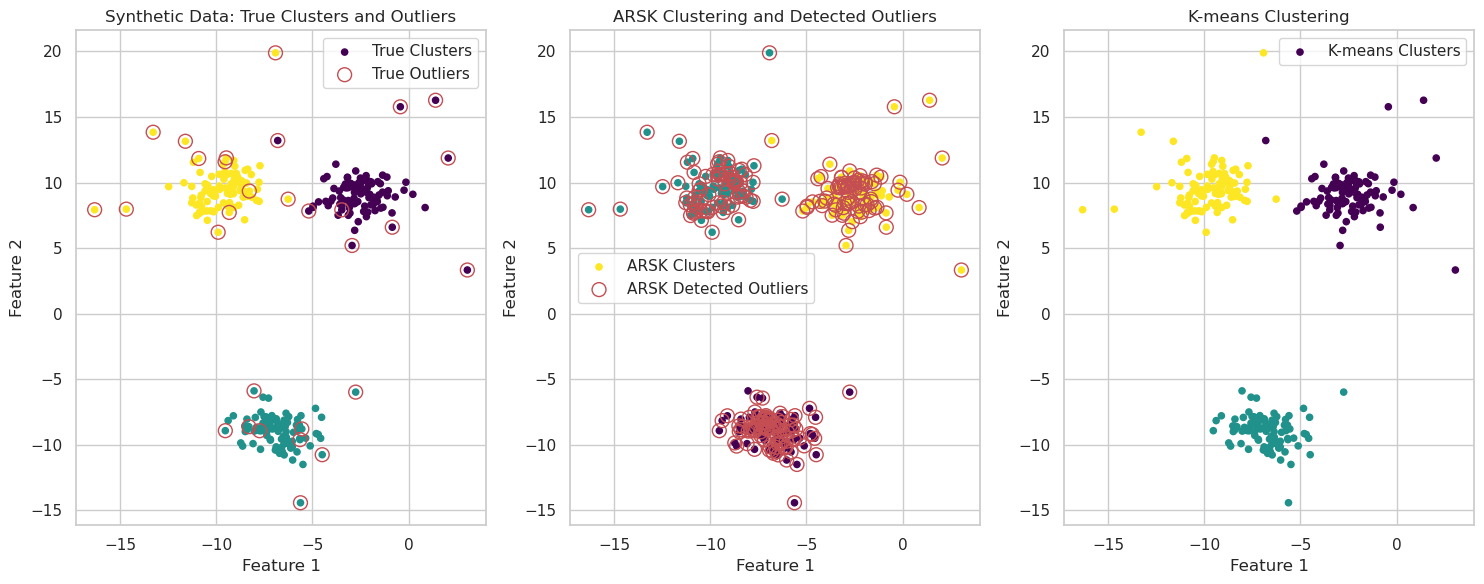

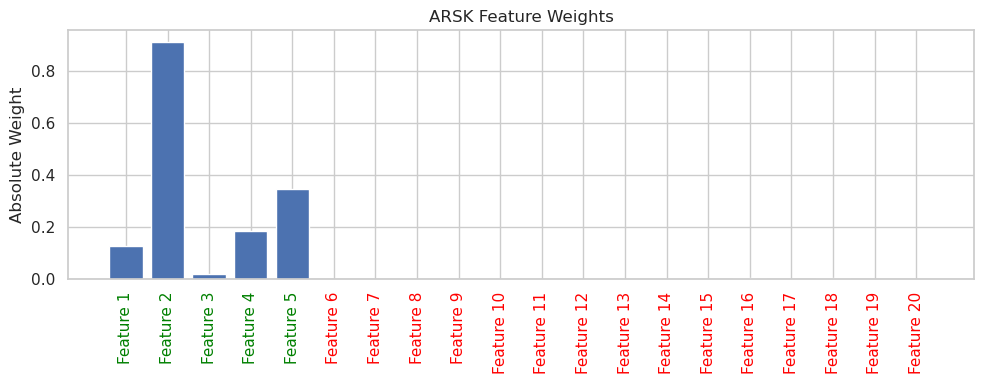

In [9]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # For comparison
import pandas as pd # To handle data easily

# Assuming the ARSK class implementation provided previously is available
# from arsk_clustering import ARSK

# 1. Generate synthetic data
n_samples = 300
n_features_informative = 5
n_features_irrelevant = 15 # Add irrelevant features
n_features = n_features_informative + n_features_irrelevant
n_clusters_synth = 3
cluster_std = 1.0
noise_level = 3.0 # For outliers

X, true_labels = make_blobs(n_samples=n_samples, n_features=n_features_informative,
                            centers=n_clusters_synth, cluster_std=cluster_std,
                            random_state=42)

# Add irrelevant features (random noise)
X_irrelevant = np.random.randn(n_samples, n_features_irrelevant) * 0.5
X_synth = np.hstack((X, X_irrelevant))

# Add outliers
n_outliers = int(0.1 * n_samples) # 10% outliers
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
X_synth[outlier_indices, :] += np.random.randn(n_outliers, n_features) * noise_level


# 2. Create an instance of the ARSK class
# Manually setting lambda1 and lambda2 for demonstration
# These values would ideally be selected by Gap Statistics
arsk = ARSK(n_clusters=n_clusters_synth, alpha=0.2, lambda1=0.5, lambda2=0.1, # Example values
            penalty_e='group_lasso', penalty_w='lasso', # Example penalties
            n_init=5, max_iter=100, random_state=42)

# 3. Fit the model to the synthetic data
print("Fitting ARSK model...")
arsk.fit(X_synth)
print("Fit complete.")

# 4. Make predictions
predicted_labels = arsk.predict(X_synth)

# 5. Evaluate the clustering performance
# We will use the Adjusted Rand Index, a common metric for comparing clusterings
# when true labels are known.
# It measures the similarity between two clusterings, ignoring permutations.
# A score of 1.0 is a perfect match.
ari_arsk = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARSK): {ari_arsk:.4f}")

# Also evaluate standard K-means for comparison
kmeans = KMeans(n_clusters=n_clusters_synth, n_init=10, random_state=42)
kmeans.fit(X_synth)
predicted_labels_kmeans = kmeans.labels_
ari_kmeans = adjusted_rand_score(true_labels, predicted_labels_kmeans)
print(f"Adjusted Rand Index (K-means): {ari_kmeans:.4f}")


# 6. Identify detected outliers
detected_outlier_indices = arsk.evaluate(X_synth)['outlier_indices']
print(f"Number of detected outliers by ARSK: {len(detected_outlier_indices)}")
# Compare with true outliers: how many true outliers were detected?
true_outlier_count_in_detected = len(set(outlier_indices).intersection(detected_outlier_indices))
print(f"Number of true outliers detected by ARSK: {true_outlier_count_in_detected}")
# How many non-outliers were incorrectly identified as outliers?
false_positive_outliers = len(detected_outlier_indices) - true_outlier_count_in_detected
print(f"Number of non-outliers incorrectly detected as outliers: {false_positive_outliers}")


# 7. Identify selected features based on weights
feature_weights = arsk.weights_
# Features with weights close to zero are considered less important or irrelevant.
# We can set a threshold to consider a weight as effectively zero.
weight_threshold = 1e-3
selected_features = np.where(np.abs(feature_weights) > weight_threshold)[0]
irrelevant_feature_indices = np.arange(n_features_informative, n_features)
# How many informative features were selected?
informative_features_selected = len(set(np.arange(n_features_informative)).intersection(selected_features))
print(f"Number of informative features selected by ARSK: {informative_features_selected} out of {n_features_informative}")
# How many irrelevant features were incorrectly selected?
irrelevant_features_selected = len(set(irrelevant_feature_indices).intersection(selected_features))
print(f"Number of irrelevant features incorrectly selected by ARSK: {irrelevant_features_selected} out of {n_features_irrelevant}")


# 8. Visualizations
# Due to high dimensionality, we can't visualize all features at once.
# Let's visualize the first two informative features, highlighting clusters and outliers.

plt.figure(figsize=(15, 6))

# Plot Original Data (showing true clusters and outliers)
plt.subplot(1, 3, 1)
scatter = plt.scatter(X_synth[:, 0], X_synth[:, 1], c=true_labels, cmap='viridis', s=20, label='True Clusters')
# Highlight true outliers
plt.scatter(X_synth[outlier_indices, 0], X_synth[outlier_indices, 1], facecolors='none', edgecolors='r', s=100, label='True Outliers')
plt.title('Synthetic Data: True Clusters and Outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot ARSK Clustering and Detected Outliers
plt.subplot(1, 3, 2)
scatter = plt.scatter(X_synth[:, 0], X_synth[:, 1], c=predicted_labels, cmap='viridis', s=20, label='ARSK Clusters')
# Highlight detected outliers by ARSK
plt.scatter(X_synth[detected_outlier_indices, 0], X_synth[detected_outlier_indices, 1], facecolors='none', edgecolors='r', s=100, label='ARSK Detected Outliers')
plt.title('ARSK Clustering and Detected Outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot K-means Clustering for comparison
plt.subplot(1, 3, 3)
scatter = plt.scatter(X_synth[:, 0], X_synth[:, 1], c=predicted_labels_kmeans, cmap='viridis', s=20, label='K-means Clusters')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Feature Weights
plt.figure(figsize=(10, 4))
feature_names = [f'Feature {i+1}' for i in range(n_features)]
plt.bar(feature_names, np.abs(feature_weights))
plt.xticks(rotation=90)
plt.ylabel('Absolute Weight')
plt.title('ARSK Feature Weights')
# Highlight informative vs irrelevant features
for i in range(n_features_informative):
    plt.gca().get_xticklabels()[i].set_color('green')
for i in range(n_features_informative, n_features):
    plt.gca().get_xticklabels()[i].set_color('red')
plt.tight_layout()
plt.show()

### Applying Elbow Method

Estimating optimal K for ARSK in range range(2, 11)...
  Testing K = 2...
  Testing K = 3...
  Testing K = 4...
  Testing K = 5...
  Testing K = 6...
  Testing K = 7...
  Testing K = 8...
  Testing K = 9...
  Testing K = 10...

--- K Selection Results ---
K=2: Gap=nan
K=3: Gap=nan
K=4: Gap=nan
K=5: Gap=nan
K=6: Gap=nan
K=7: Gap=nan
K=8: Gap=nan
K=9: Gap=nan
K=10: Gap=nan

Suggested optimal K: None


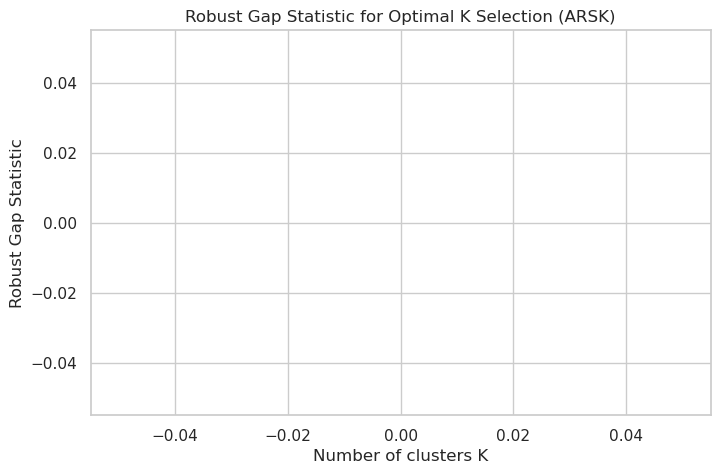

In [11]:
# Código conceitual (não funcional completo) para ilustrar a estrutura
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans # Para dados de referência
import matplotlib.pyplot as plt

# Importe a classe ARSK implementada anteriormente
# from arsk_clustering import ARSK

def calculate_robust_weighted_bcss(X, E, labels, weights):
    """
    Calcula uma medida robusta e ponderada de dispersão entre clusters (D_R).
    Baseado no conceito de Q_j^R ponderado pelos pesos w_j.
    D_R = sum_j w_j * Q_j^R(X_{:,j}; Theta, E_{:,j})
    Onde Q_j^R é proporcional ao Between-cluster SS em X' = X - E.
    Portanto, D_R é proporcional a sum_j w_j * (Between-cluster SS for feature j on X').
    """
    # Esta função precisaria da lógica de _calculate_qr e ponderação pelos pesos.
    # A implementação exata de D_R no artigo [cite: 93] é D_{\lambda_2, \lambda_1}^{R} = sum_j w_j Q_j^R.
    # Portanto, precisamos do Q_j^R calculado nos dados ajustados (X-E) e dos pesos finais.
    X_prime = X - E
    Qr_j = ARSK._calculate_qr(None, X_prime, labels) # Reusing _calculate_qr logic from ARSK class
    D_R = np.sum(weights * Qr_j) # Sum w_j * Q_j^R

    # O Gap estatístico usa log(D_R), então D_R deve ser positivo.
    # Garanta que Qr_j e, portanto, D_R sejam não negativos (Between SS é não negativo).
    # Se D_R for zero ou negativo (devido a pequenos erros numéricos ou clusters triviais),
    # ajustar para um valor pequeno positivo para log.
    return np.maximum(D_R, 1e-9)


def estimate_optimal_k_with_arsk_gap(X, k_range, alpha, lambda1=None, lambda2=None,
                                     penalty_e='group_lasso', penalty_w='lasso',
                                     n_init=10, max_iter=100, tol=1e-4, random_state=None,
                                     n_perms=25):
    """
    Esboço da função para estimar o número ótimo de clusters K para ARSK usando Gap Statistics.
    NOTA: Esta é uma versão conceitual. Implementar a seleção de lambda1/lambda2 internamente
    para cada K, e rodar ARSK em dados permutados é complexo e não totalmente demonstrado aqui.

    Args:
        X (np.ndarray): O conjunto de dados de entrada.
        k_range (list or range): Uma lista ou range de valores de K a serem testados.
        alpha, lambda1, lambda2, ...: Parâmetros para a classe ARSK.
        n_perms (int): Número de datasets permutados para o cálculo da Gap Statistics.

    Returns:
        dict: Resultados contendo Gap Statistics para cada K e o K ótimo sugerido.
    """
    gap_scores = []
    optimal_k = None

    print(f"Estimating optimal K for ARSK in range {k_range}...")

    for k in k_range:
        print(f"  Testing K = {k}...")
        # 1. Ajustar ARSK nos dados reais para o K atual
        # Se lambda1 ou lambda2 forem None, idealmente eles seriam selecionados aqui
        # usando Algorithm 2 para este K fixo. Para este esboço, assumimos que lambda1/lambda2
        # são fixos para todos os K ou lidamos com seus valores None de forma simplificada.
        try:
            # Crie uma nova instância de ARSK para cada K, mantendo outros parâmetros fixos
            arsk_model = ARSK(n_clusters=k, alpha=alpha, lambda1=lambda1, lambda2=lambda2,
                              penalty_e=penalty_e, penalty_w=penalty_w,
                              n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)
            arsk_model.fit(X)

            # Obter resultados do ajuste nos dados reais
            real_labels = arsk_model.labels_
            real_weights = arsk_model.weights_
            real_error_matrix = arsk_model.error_matrix_

            # Calcular D_R para os dados reais
            d_r_real = calculate_robust_weighted_bcss(X, real_error_matrix, real_labels, real_weights)

            # 2. Calcular D_R para datasets de referência nulos (permutados)
            log_d_r_perms = []
            for b in range(n_perms):
                # Gere um dataset permutado
                X_perm = np.apply_along_axis(np.random.permutation, axis=0, arr=X)

                # Ajuste ARSK no dataset permutado (simplificado: use os mesmos lambda1/lambda2 e inicialização)
                # Uma abordagem mais robusta rodaria a seleção de lambda1/lambda2 para cada K e cada permutação.
                # Isso ilustra a complexidade total.
                try:
                     arsk_perm_model = ARSK(n_clusters=k, alpha=alpha, lambda1=lambda1, lambda2=lambda2,
                                            penalty_e=penalty_e, penalty_w=penalty_w,
                                            n_init=1, max_iter=50, # Menos iterações para permutados
                                            random_state=random_state + b + k if random_state is not None else b + k)
                     arsk_perm_model.fit(X_perm)

                     # Calcular D_R para o dataset permutado
                     d_r_perm = calculate_robust_weighted_bcss(X_perm, arsk_perm_model.error_matrix_,
                                                               arsk_perm_model.labels_, arsk_perm_model.weights_)
                     log_d_r_perms.append(np.log(d_r_perm))
                except Exception as e:
                     print(f"      Warning: ARSK fit failed for permutation {b} with K={k}. Error: {e}")
                     # Se o ajuste falhar, adicione um valor que penalize este K ou o ignore.
                     # Adicionar NaN ou um valor muito pequeno pode ser apropriado.
                     log_d_r_perms.append(np.nan) # Usar NaN para indicar falha

            # Calcular Gap Statistics para este K
            log_d_r_real = np.log(d_r_real)
            mean_log_d_r_perms = np.nanmean(log_d_r_perms) # Use nanmean para lidar com falhas
            gap_k = log_d_r_real - mean_log_d_r_perms

            # Calcular erro padrão (s_k) para a regra de um erro padrão (opcional)
            # sk = std(log_d_r_perms) * sqrt(1 + 1/n_perms)
            # Para este esboço, apenas maximizaremos o Gap.

            gap_scores.append({'k': k, 'gap': gap_k, 'log_d_r_real': log_d_r_real, 'mean_log_d_r_perms': mean_log_d_r_perms})

        except Exception as e:
             print(f"  Warning: ARSK fit failed for K={k}. Error: {e}")
             gap_scores.append({'k': k, 'gap': np.nan, 'log_d_r_real': np.nan, 'mean_log_d_r_perms': np.nan})


    # Encontrar K que maximiza o Gap (ignorando NaNs)
    valid_gap_scores = [score for score in gap_scores if not np.isnan(score['gap'])]
    if valid_gap_scores:
        optimal_k = valid_gap_scores[int(np.argmax([score['gap'] for score in valid_gap_scores]))]['k']

    return {'gap_scores': gap_scores, 'optimal_k_suggested': optimal_k}

# Exemplo de uso (requer a classe ARSK e dados X):
k_values_to_test = range(2, 11) # Testar de 2 a 10 clusters
results_k_selection = estimate_optimal_k_with_arsk_gap(X_synth, k_values_to_test, alpha=0.2,
                                                       lambda1=0.5, lambda2=0.1, # Usar os mesmos lambdas do ajuste ARSK anterior
                                                       penalty_e='group_lasso', penalty_w='lasso',
                                                       n_init=5, max_iter=50, # Reduzir max_iter para seleção de K
                                                       random_state=42, n_perms=10) # Reduzir n_perms para teste

print("\n--- K Selection Results ---")
for score in results_k_selection['gap_scores']:
    print(f"K={score['k']}: Gap={score['gap']:.4f}")

print(f"\nSuggested optimal K: {results_k_selection['optimal_k_suggested']}")

# Plot Gap Statistics
if results_k_selection['gap_scores']:
    k_values = [score['k'] for score in results_k_selection['gap_scores']]
    gap_values = [score['gap'] for score in results_k_selection['gap_scores']]
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, gap_values, marker='o')
    plt.xlabel('Number of clusters K')
    plt.ylabel('Robust Gap Statistic')
    plt.title('Robust Gap Statistic for Optimal K Selection (ARSK)')
    if results_k_selection['optimal_k_suggested'] is not None:
        plt.axvline(x=results_k_selection['optimal_k_suggested'], color='r', linestyle='--', label=f'Suggested K={results_k_selection["optimal_k_suggested"]}')
        plt.legend()
    plt.grid(True)
    plt.show()

### Applying ARSKC

In [44]:
import pandas as pd
# dataset = pd.read_csv('/root/.cache/kagglehub/datasets/yogidsba/us-highway-railgrade-crossing-accident/versions/1/Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False, sep=',')
dataset = pd.read_csv('datasets/Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False, sep=',')

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239487 entries, 0 to 239486
Columns: 141 entries, Railroad Code to Report Key
dtypes: float64(50), int64(12), object(79)
memory usage: 257.6+ MB


In [26]:
dataset.head()

,Railroad Code,Railroad Name,Report Year,Incident Number,Incident Year,Incident Month,Other Railroad Code,Other Railroad Name,Other Incident Number,Other Incident Year,...,Total Killed Form 57,Total Injured Form 57,Railroad Type,Joint Code,Total Killed Form 55A,Total Injured Form 55A,District,Whistle Ban Code,Whistle Ban,Report Key
0,BNSF,BNSF Railway Company,2009,CA0109200,9,1,NaN,NaN,NaN,NaN,...,0,1,1L,1,0,1,7.0,2.0,No,BNSFCA0109200200901
1,BNSF,BNSF Railway Company,2009,CA0109201,9,1,NaN,NaN,NaN,NaN,...,1,6,1L,1,1,6,7.0,2.0,No,BNSFCA0109201200901
2,NS,Norfolk Southern Railway Company,2020,139633,20,11,NaN,NaN,NaN,NaN,...,0,0,1,1,0,0,3.0,NaN,NaN,NS139633202011
3,BNSF,BNSF Railway Company,2008,CA0208200,8,2,NaN,NaN,NaN,NaN,...,0,2,1L,1,0,2,7.0,2.0,No,BNSFCA0208200200802
4,BNSF,BNSF Railway Company,2008,CA0208201,8,2,NaN,NaN,NaN,NaN,...,0,1,1L,1,0,1,7.0,2.0,No,BNSFCA0208201200802


In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Seu código existente
features = [
    # --- Resultados Diretos (Vítimas e Custo) ---
    'Crossing Users Killed For Reporting Railroad',
    'Crossing Users Injured For Reporting Railroad',
    'Employees Killed For Reporting Railroad',
    'Employees Injured For Reporting Railroad',
    'Passengers Killed For Reporting Railroad',
    'Passengers Injured For Reporting Railroad',
    'Total Killed Form 57',
    'Total Injured Form 57',
    'Total Killed Form 55A',
    'Total Injured Form 55A',
    'Vehicle Damage Cost',

    # --- Fatores Contribuintes e Contexto ---
    # Comportamento e Situação do Usuário da Via
    'Highway User Position Code',
    'Highway User Action Code',
    'View Obstruction Code',

    # Infraestrutura e Sinalização da Passagem
    # 'Crossing Warning Expanded Code 1',
    # 'Crossing Warning Expanded Code 2',
    # 'Crossing Warning Expanded Code 3',
    # 'Crossing Warning Expanded Code 4',
    # 'Crossing Warning Expanded Code 5', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 6', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 7', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 8', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 9', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 10', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 11', - Poucas Linhas com dados Non-Null
    'Crossing Warning Expanded Code 12',
    'Signaled Crossing Warning Code',
    # 'Crossing Warning Explanation Code',
    'Warning Connected To Signal',
    'Crossing Illuminated',

    # Condições Ambientais
    'Roadway Condition Code',
    'Weather Condition Code',
    'Visibility Code',

    # Características do Trem e Carga
    'Hazmat Involvement Code',
    'Hazmat Released by Code',
    'Train Speed',
    'Equipment Type Code'
]

In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que seu DataFrame 'dataset' já esteja carregado
# e a variável 'features' contenha a lista das colunas numéricas originais

X = dataset[features]

# 1. Identificar as colunas categóricas para one-hot encoding
categorical_cols = [
  'Signaled Crossing Warning Code',
  'Warning Connected To Signal',
  'Crossing Illuminated',
  'Roadway Condition Code',
  'Equipment Type Code'
]

# 2. Aplicar o One-Hot Encoding
dataset_encoded = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)

# 3. Identificar as novas features (incluindo as numéricas originais e as codificadas)
# Vamos assumir que as colunas numéricas originais estavam em uma lista chamada 'features' antes do encoding.
# Agora, precisamos criar uma nova lista de features para o RSKC, que incluirá as colunas numéricas originais
# e as novas colunas criadas pelo one-hot encoding.

# Para fazer isso, podemos pegar todas as colunas do dataset_encoded que não são as colunas originais categóricas
# e também não são as colunas que adicionamos depois ('cluster' e 'is_outlier', se já existirem).
features_encoded = [col for col in dataset_encoded.columns if col not in categorical_cols and col not in ['cluster', 'is_outlier']]
numerical_features_encoded = dataset_encoded[features_encoded].select_dtypes(include=np.number).columns.tolist()

# 4. Aplicar o StandardScaler nas features codificadas
X = dataset_encoded[numerical_features_encoded]
X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
X.shape

(239487, 20)

In [34]:
# Aplicando o RSKC
# Defina os parâmetros
n_clusters = 3       # Número de clusters
alpha = 0.1          # Proporção de outliers (10%)
L1 = 5               # Restrição L1 para esparsidade (controla quantas features serão selecionadas)
nstart = 50          # Número de inicializações aleatórias

# Executando o algoritmo
rskc_result = ARSK(d=X_scaled, ncl=n_clusters, alpha=alpha, L1=L1, nstart=nstart)

TypeError: ARSK.__init__() got an unexpected keyword argument 'd'

### Applying K-Means

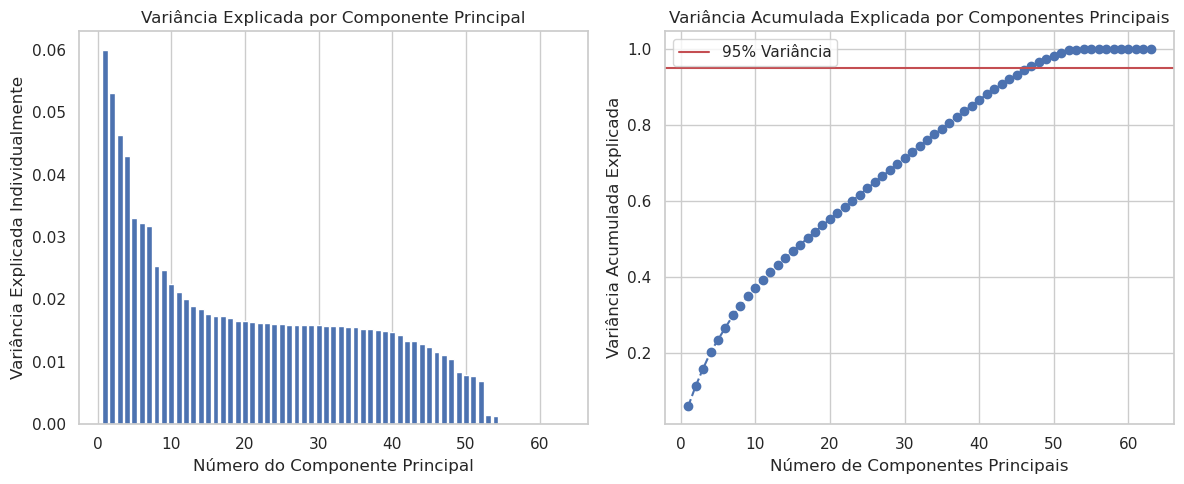


Visualizando clusters K-means nos 3 primeiros componentes principais:


/tmp/ipykernel_8603/1004956722.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


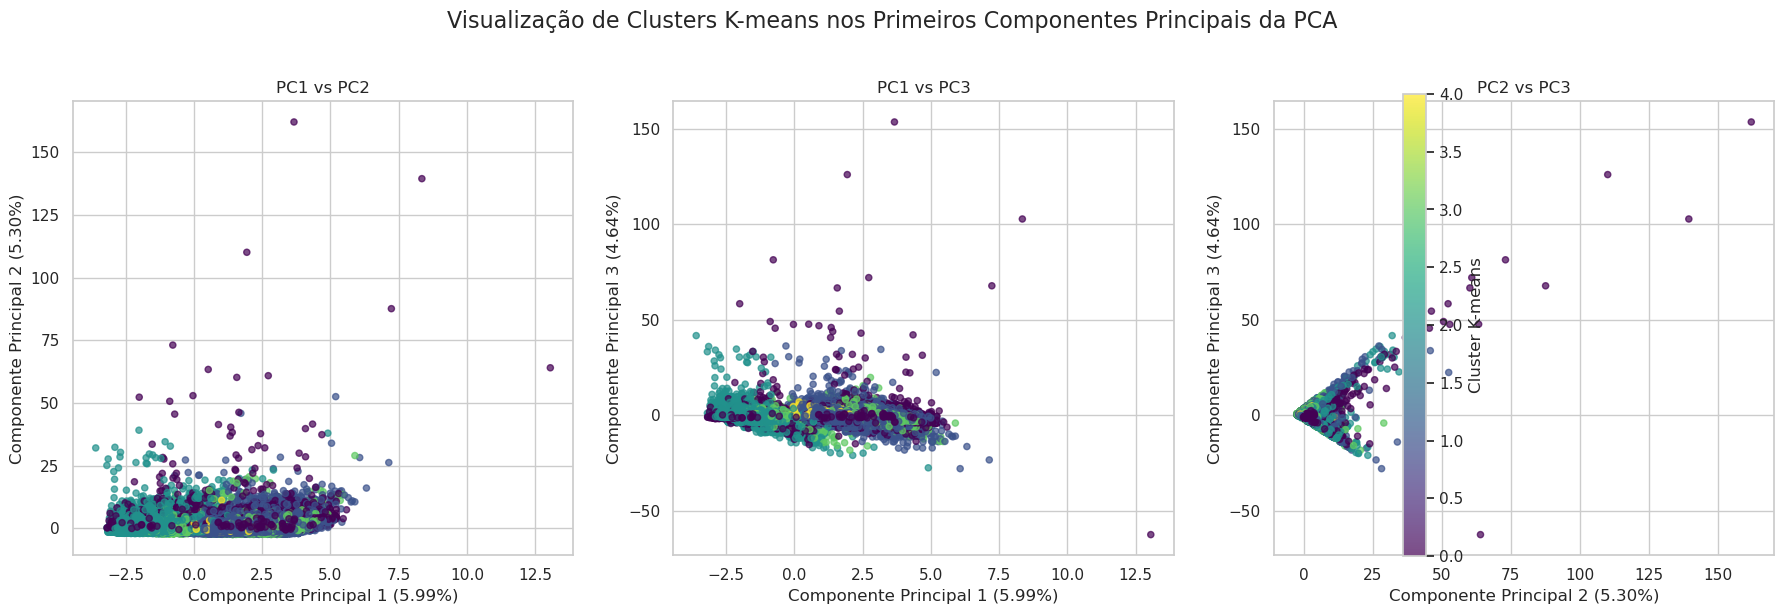

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que seu DataFrame 'dataset' já esteja carregado
# e a variável 'features' contenha a lista das colunas numéricas originais
# Certifique-se que 'dataset' está definido e carregado aqui, por exemplo:
# dataset = pd.read_csv('seu_arquivo.csv') # Substitua pelo seu método de carregamento

# Seu código de pré-processamento (mantido do exemplo anterior)
features = [
    # --- Resultados Diretos (Vítimas e Custo) ---
    'Crossing Users Killed For Reporting Railroad', 'Crossing Users Injured For Reporting Railroad',
    'Employees Killed For Reporting Railroad', 'Employees Injured For Reporting Railroad',
    'Passengers Killed For Reporting Railroad', 'Passengers Injured For Reporting Railroad',
    'Total Killed Form 57', 'Total Injured Form 57',
    'Total Killed Form 55A', 'Total Injured Form 55A',
    'Vehicle Damage Cost',

    # --- Fatores Contribuintes e Contexto ---
    # Comportamento e Situação do Usuário da Via
    'Highway User Position Code', 'Highway User Action Code', 'View Obstruction Code',

    # Infraestrutura e Sinalização da Passagem
    'Crossing Warning Expanded Code 12',
    'Signaled Crossing Warning Code',
    'Warning Connected To Signal', 'Crossing Illuminated',

    # Condições Ambientais
    'Roadway Condition Code', 'Weather Condition Code', 'Visibility Code',

    # Características do Trem e Carga
    'Hazmat Involvement Code', 'Hazmat Released by Code', 'Train Speed', 'Equipment Type Code'
]

# Seleciona as features e trata NaNs (manter consistência)
X = dataset[features].copy() # Usar .copy() para evitar SettingWithCopyWarning
X = X.fillna(0) # Exemplo simples de tratamento de NaNs, ajuste conforme sua análise de dados

# 1. Identificar as colunas categóricas para one-hot encoding
categorical_cols = [
    'Signaled Crossing Warning Code',
    'Warning Connected To Signal',
    'Crossing Illuminated',
    'Roadway Condition Code',
    'Equipment Type Code'
]

# Validar se as colunas categóricas existem em X antes do encoding
categorical_cols_existing = [col for col in categorical_cols if col in X.columns]
if len(categorical_cols_existing) < len(categorical_cols):
    print(f"Aviso: Algumas colunas categóricas não encontradas nas features selecionadas: {list(set(categorical_cols) - set(categorical_cols_existing))}")

# 2. Aplicar o One-Hot Encoding
# O get_dummies já lida com colunas que não existem na lista 'columns', apenas as existentes são codificadas
X_encoded = pd.get_dummies(X, columns=categorical_cols_existing, prefix=categorical_cols_existing)

# 3. Identificar as features numéricas resultantes (originais numéricas + one-hot)
# Todas as colunas agora são numéricas (ou binárias do one-hot)
numerical_features_encoded = X_encoded.columns.tolist() # Todas as colunas agora são features numéricas para o escalonamento

# 4. Aplicar o StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded[numerical_features_encoded]) # Escala TODAS as colunas resultantes

# 5. Aplicar K-means Clustering nos dados escalonados
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(X_scaled)
predicted_labels_kmeans = kmeans.labels_

# --- Parte Nova: Visualização com PCA Detalhada ---

# 6. Análise de Variância Explicada com PCA (sem reduzir a dimensão ainda)
# Aplicamos PCA a todos os componentes possíveis para entender a distribuição da variância
pca_full = PCA(n_components=None)
pca_full.fit(X_scaled)

# Plotar a Variância Explicada por cada Componente e a Variância Acumulada
plt.figure(figsize=(12, 5))

# Gráfico da Variância Explicada por Componente
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_)
plt.xlabel('Número do Componente Principal')
plt.ylabel('Variância Explicada Individualmente')
plt.title('Variância Explicada por Componente Principal')
plt.grid(axis='y')

# Gráfico da Variância Acumulada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Acumulada Explicada')
plt.title('Variância Acumulada Explicada por Componentes Principais')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variância') # Linha de referência (ex: 95%)
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta o layout para não sobrepor
plt.show()

# 7. Aplicar PCA para reduzir a dimensionalidade para os 3 primeiros componentes para visualização
# Com base nos gráficos acima, você pode decidir quantos componentes fazem sentido.
# Vamos pegar os 3 primeiros como exemplo para visualização 2D par a par.
n_components_viz = 3
pca_viz = PCA(n_components=n_components_viz)
X_pca_viz = pca_viz.fit_transform(X_scaled)

# 8. Plotar os resultados do K-means usando pares dos 3 primeiros componentes principais
print(f"\nVisualizando clusters K-means nos {n_components_viz} primeiros componentes principais:")

# Criar subplots para os gráficos de pares
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 3 gráficos lado a lado

# Par 1: PC1 vs PC2
scatter1 = axes[0].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], c=predicted_labels_kmeans, cmap='viridis', s=20, alpha=0.7)
axes[0].set_title('PC1 vs PC2')
axes[0].set_xlabel(f'Componente Principal 1 ({pca_viz.explained_variance_ratio_[0]*100:.2f}%)')
axes[0].set_ylabel(f'Componente Principal 2 ({pca_viz.explained_variance_ratio_[1]*100:.2f}%)')
axes[0].grid(True)

# Par 2: PC1 vs PC3
scatter2 = axes[1].scatter(X_pca_viz[:, 0], X_pca_viz[:, 2], c=predicted_labels_kmeans, cmap='viridis', s=20, alpha=0.7)
axes[1].set_title('PC1 vs PC3')
axes[1].set_xlabel(f'Componente Principal 1 ({pca_viz.explained_variance_ratio_[0]*100:.2f}%)')
axes[1].set_ylabel(f'Componente Principal 3 ({pca_viz.explained_variance_ratio_[2]*100:.2f}%)')
axes[1].grid(True)

# Par 3: PC2 vs PC3
scatter3 = axes[2].scatter(X_pca_viz[:, 1], X_pca_viz[:, 2], c=predicted_labels_kmeans, cmap='viridis', s=20, alpha=0.7)
axes[2].set_title('PC2 vs PC3')
axes[2].set_xlabel(f'Componente Principal 2 ({pca_viz.explained_variance_ratio_[1]*100:.2f}%)')
axes[2].set_ylabel(f'Componente Principal 3 ({pca_viz.explained_variance_ratio_[2]*100:.2f}%)')
axes[2].grid(True)

# Adicionar uma colorbar comum a todos os gráficos
fig.colorbar(scatter1, ax=axes.ravel().tolist(), label='Cluster K-means')

plt.suptitle('Visualização de Clusters K-means nos Primeiros Componentes Principais da PCA', y=1.02, fontsize=16) # Título geral
plt.tight_layout()
plt.show()

# Opcional: Adicionar os rótulos dos clusters de volta ao DataFrame original
dataset['kmeans_cluster'] = predicted_labels_kmeans


Aviso: Algumas colunas binárias de exemplo não encontradas. Verifique os nomes após o one-hot encoding: ['Warning Connected To Signal_Y', 'Crossing Illuminated_Y', 'Roadway Condition Code_1']

Visualizando distribuição de features por cluster K-means:


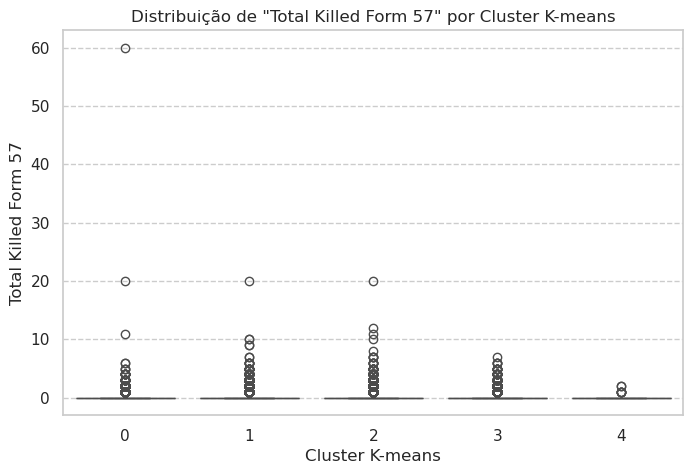

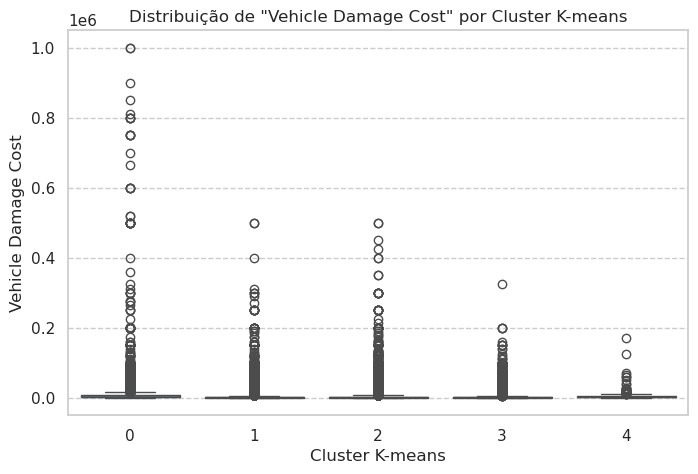

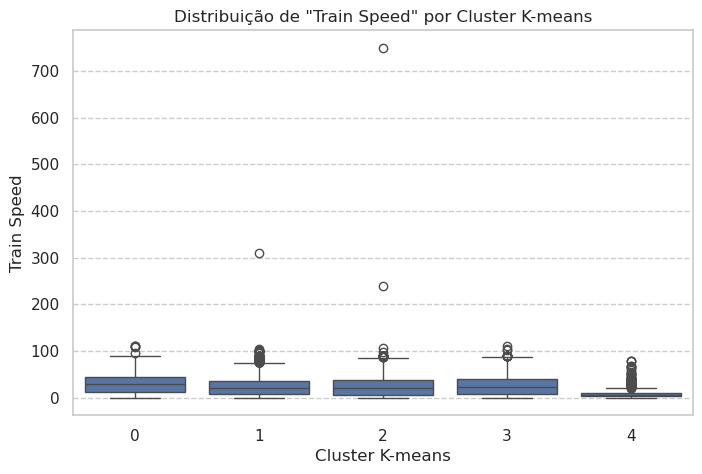


Visualizando proporção de categorias (features binárias) por cluster K-means:


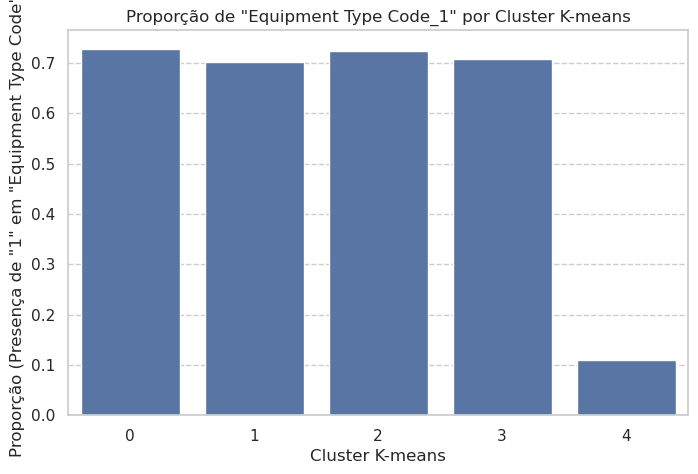

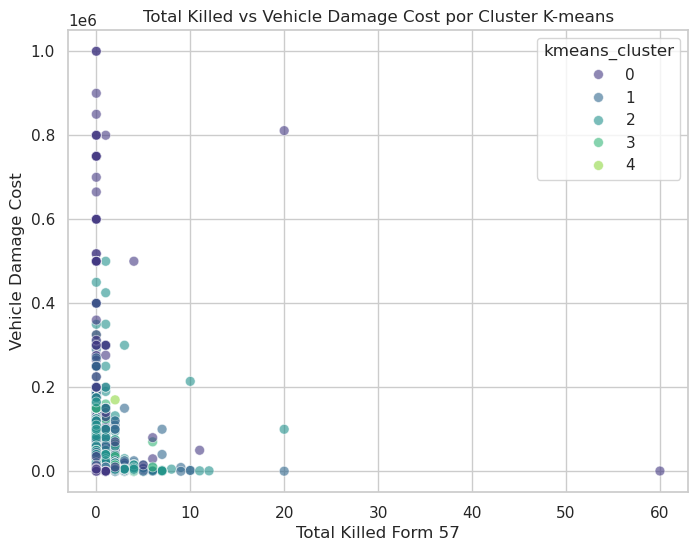

In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # Mantemos o import caso queira referenciar PCA, mas não será usado na visualização principal aqui
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que seu DataFrame 'dataset' já esteja carregado e pré-processado até X_encoded e X_scaled
# E que 'predicted_labels_kmeans' contém os rótulos dos clusters

# --- Código de Pré-processamento (reproduzido para contexto) ---
features = [
    # --- Resultados Diretos (Vítimas e Custo) ---
    'Crossing Users Killed For Reporting Railroad', 'Crossing Users Injured For Reporting Railroad',
    'Employees Killed For Reporting Railroad', 'Employees Injured For Reporting Railroad',
    'Passengers Killed For Reporting Railroad', 'Passengers Injured For Reporting Railroad',
    'Total Killed Form 57', 'Total Injured Form 57',
    'Total Killed Form 55A', 'Total Injured Form 55A',
    'Vehicle Damage Cost',

    # --- Fatores Contribuintes e Contexto ---
    # Comportamento e Situação do Usuário da Via
    'Highway User Position Code', 'Highway User Action Code', 'View Obstruction Code',

    # Infraestrutura e Sinalização da Passagem
    'Crossing Warning Expanded Code 12',
    'Signaled Crossing Warning Code',
    'Warning Connected To Signal', 'Crossing Illuminated',

    # Condições Ambientais
    'Roadway Condition Code', 'Weather Condition Code', 'Visibility Code',

    # Características do Trem e Carga
    'Hazmat Involvement Code', 'Hazmat Released by Code', 'Train Speed', 'Equipment Type Code'
]

# Certifique-se que 'dataset' está definido e carregado aqui.
# dataset = pd.read_csv('seu_arquivo.csv') # Exemplo de carregamento

# Seleciona as features e trata NaNs (manter consistência)
X = dataset[features].copy()
X = X.fillna(0) # Ajuste conforme sua análise de dados

# Colunas categóricas originais
categorical_cols = [
    'Signaled Crossing Warning Code',
    'Warning Connected To Signal',
    'Crossing Illuminated',
    'Roadway Condition Code',
    'Equipment Type Code'
]

# Aplicar One-Hot Encoding
categorical_cols_existing = [col for col in categorical_cols if col in X.columns]
X_encoded = pd.get_dummies(X, columns=categorical_cols_existing, prefix=categorical_cols_existing)

# Aplicar StandardScaler (necessário para o K-means, mas não para a visualização das features originais/encoded)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_encoded) # Não precisamos de X_scaled diretamente para esta visualização

# Aplicar K-means para obter os rótulos (assumimos que já foi rodado e predicted_labels_kmeans existe)
# kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
# kmeans.fit(X_scaled)
# predicted_labels_kmeans = kmeans.labels_

# --- Foco na Visualização Conforme os Dados ---

# 1. Adicionar os rótulos dos clusters ao DataFrame processado
X_visualizacao = X_encoded.copy()
X_visualizacao['kmeans_cluster'] = predicted_labels_kmeans

# Convertendo a coluna de cluster para categórica para melhor visualização com Seaborn
X_visualizacao['kmeans_cluster'] = X_visualizacao['kmeans_cluster'].astype('category')


# 2. Selecionar algumas features para visualização
# Escolha features numéricas originais e algumas das que foram one-hot encoded
features_numericas_originais_exemplo = [
    'Total Killed Form 57',
    'Vehicle Damage Cost',
    'Train Speed'
]

# Exemplos de features binárias resultantes do one-hot encoding
# Escolha algumas categorias específicas das colunas categóricas
# Você precisará verificar os nomes exatos das colunas criadas pelo get_dummies
# Ex: se 'Roadway Condition Code' tinha valores 'A' e 'B', get_dummies criaria 'Roadway Condition Code_A' e 'Roadway Condition Code_B'
# Substitua pelos nomes reais baseados nos seus dados
features_binarias_exemplo = [
    'Warning Connected To Signal_Y', # Exemplo: assumindo que 'Y' é uma categoria
    'Crossing Illuminated_Y',      # Exemplo: assumindo que 'Y' é uma categoria
    'Roadway Condition Code_1',    # Exemplo: assumindo '1' é um código de condição
    'Equipment Type Code_1'        # Exemplo: assumindo '1' é um código de equipamento
]

# Certificar que as colunas de exemplo binárias existem no DataFrame
features_binarias_existente = [col for col in features_binarias_exemplo if col in X_visualizacao.columns]
if len(features_binarias_existente) < len(features_binarias_exemplo):
     print(f"\nAviso: Algumas colunas binárias de exemplo não encontradas. Verifique os nomes após o one-hot encoding: {list(set(features_binarias_exemplo) - set(features_binarias_existente))}")
     features_binarias_exemplo = features_binarias_existente # Usar apenas as que existem


# 3. Gerar gráficos de distribuição por cluster

print("\nVisualizando distribuição de features por cluster K-means:")

# Gráficos para features numéricas originais
for feature in features_numericas_originais_exemplo:
    if feature in X_visualizacao.columns:
        plt.figure(figsize=(8, 5))
        # Usamos boxplot para ver a distribuição (mediana, quartis, outliers)
        sns.boxplot(x='kmeans_cluster', y=feature, data=X_visualizacao)
        plt.title(f'Distribuição de "{feature}" por Cluster K-means')
        plt.xlabel('Cluster K-means')
        plt.ylabel(feature)
        plt.grid(axis='y', linestyle='--')
        plt.show()
    else:
        print(f"Aviso: Feature numérica '{feature}' não encontrada para visualização.")

# Gráficos para features binárias (resultantes do one-hot encoding)
# Para features binárias, calcular a proporção de 1s por cluster
print("\nVisualizando proporção de categorias (features binárias) por cluster K-means:")

for feature_binaria in features_binarias_exemplo:
     if feature_binaria in X_visualizacao.columns:
        plt.figure(figsize=(8, 5))
        # Calcula a média da feature binária (que é a proporção de 1s) agrupado por cluster
        proportion_by_cluster = X_visualizacao.groupby('kmeans_cluster')[feature_binaria].mean().reset_index()
        sns.barplot(x='kmeans_cluster', y=feature_binaria, data=proportion_by_cluster)
        plt.title(f'Proporção de "{feature_binaria}" por Cluster K-means')
        plt.xlabel('Cluster K-means')
        plt.ylabel(f'Proporção (Presença de "{feature_binaria.split("_")[-1]}" em "{feature_binaria.split("_")[0]}")') # Tenta criar um label mais legível
        plt.grid(axis='y', linestyle='--')
        plt.show()
     else:
        print(f"Aviso: Feature binária '{feature_binaria}' não encontrada para visualização.")


# Opcional: Scatter plots de pares de features originais (se houver alguma combinação interessante)
# Você pode escolher 2 ou 3 features numéricas originais para um scatter plot 2D ou 3D
# Exemplo: Scatter plot de Total Killed vs Vehicle Damage Cost por cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Total Killed Form 57', y='Vehicle Damage Cost', hue='kmeans_cluster', data=X_visualizacao, palette='viridis', s=50, alpha=0.6)
plt.title('Total Killed vs Vehicle Damage Cost por Cluster K-means')
plt.xlabel('Total Killed Form 57')
plt.ylabel('Vehicle Damage Cost')
plt.grid(True)
plt.show()